# Module example

Can be found here: https://github.com/pierre-rouanet/dtw

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import astropy.io.fits as pf
from collections import defaultdict

from dtw import dtw, accelerated_dtw
from fastdtw import fastdtw

%matplotlib inline

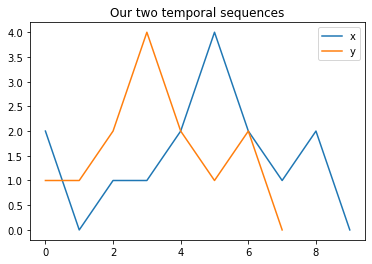

In [6]:
# We define two sequences x, y as numpy array
# where y is actually a sub-sequence from x
x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)

plt.plot(x, label='x')
plt.plot(y, label='y')
plt.title('Our two temporal sequences')
plt.legend()

0.1111111111111111


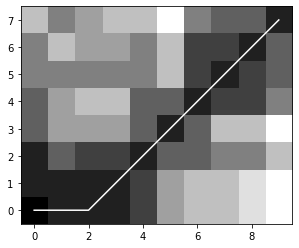

In [7]:
euclidean_norm = lambda x, y: np.abs(x - y)

d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=euclidean_norm)

print(d)

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

In [8]:
path

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 0, 0, 1, 2, 3, 4, 5, 6, 7]))

In [9]:
zipped_path = zip(path[0], path[1])

path_dict = defaultdict(list)
for i, j in zipped_path:
    path_dict[j].append(i)
    
    
aligned_x = []    
for i, j in path_dict.items():
    aj = [x[t] for t in j]
    aligned_x.insert(i, np.mean(aj))

In [10]:
aligned_x

[1.0, 1.0, 2.0, 4.0, 2.0, 1.0, 2.0, 0.0]

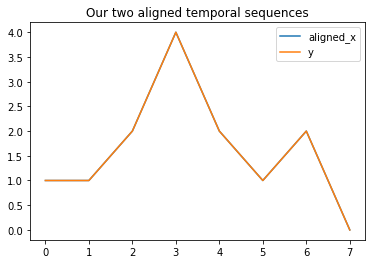

In [11]:
plt.plot(aligned_x, label='aligned_x')
plt.plot(y, label='y')
plt.title('Our two aligned temporal sequences')
plt.legend()

# Testing on stellar data

In [12]:
def get_flux_and_wavelength(file):
    flux = pf.getdata(file)
    spec_header = pf.getheader(file)
    
    wl_i = spec_header['CRVAL1'] # Coordinate value of position in degrees, specified in CRPIX.
    wl_step = spec_header['CDELT1'] # Increment-per-pixel of axis n, in degrees
    wavelength = np.arange(flux.size)*wl_step+wl_i
    
    return flux, wavelength

In [6]:
def zero_clip_flux(a):
    return np.clip(a, 0., None)

In [13]:
ardata = pf.open('spectra/ardata.fits')
data = ardata[1].data

wl_ardata = data['WAVELENGTH']
# arcturus_flux = zero_clip_flux(data['ARCTURUS'])
solar_flux = data['SOLARFLUX']
tel_flux = data['TELLURIC']

O primeiro problema ao tentar usar a implementação naive do algoritmo é que ele tem complexidade de tempo e espaço O(N^2), por isso o erro de memória ao tentar usar em vetores com 700 mil elementos

In [8]:
d, cost_matrix, acc_cost_matrix, path = dtw(solar_flux, tel_flux, dist=euclidean_norm)

MemoryError: 

### DTW

Aqui estamos tentando diminuir os vetores de fluxo para conseguir usar esta implementação do algoritmo. Com 2000 elementos, a execução deixa de ser instantânea e passa a demorar ~30 segundos. Além de não conseguirmos aumentar muito mais a quantidade de elememtos, o warp path deste começo parece ser exatamente alinhado.

In [12]:
threshold = 2000

test_solar_flux = solar_flux[:threshold]
test_tel_flux = tel_flux[:threshold]

In [13]:
start = time.time()

d, cost_matrix, acc_cost_matrix, path = dtw(test_solar_flux, test_tel_flux, dist=euclidean_norm)

end = time.time()
print('Elapsed time in seconds: {}'.format(end - start))

Elapsed time in seconds: 18.938528299331665


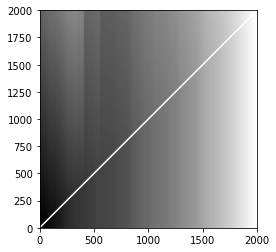

In [14]:
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

In [39]:
d

0.2627830501049757

In [40]:
all(x == y for x, y in zip(path[0], path[1]))

True

### FastDTW

Com a versão rápida implementada, foi possível usar a norma euclideana como medida de similaridade para computar o caminho ótimo entre dois fluxos: o do Sol e o da estrela telúrica. Nesse caso a complexidade do algoritmo, tanto de tempo quanto de espaço é linear. Aqui é possível observar a mesma coisa que na implementação simples: a primeira metade do warp path entre os fluxos é exatamente alinhado. Isso parece acontecer pois o caminho ótimo entre os fluxos é maior do que o comprimento inicial dos mesmos. No caso de Arcturus com a estrela telúrica o caminho é quase o dobro dos vetores originais. Usar a distância euclideana do scipy piora significativamente a performance do algoritmo, então estamos usando uma implementação simples da norma euclideana.

In [43]:
def plot_spectrum(new_wavelength, new_flux):
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.plot(new_wavelength, new_flux, '-')
    plt.xlabel(r"Wavelength ($\mathrm{\AA}$)")
    plt.ylabel(r"Flux")
#     plt.show()

In [15]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    print(idx - 1, idx)
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

In [16]:
len(solar_flux)

762078

In [17]:
len(tel_flux)

762078

In [18]:
find_nearest(wl_ardata, 4950)

236553 236554


4950.0017

In [19]:
wl_ardata[236554]

4950.0017

In [20]:
def fast_dtw_on_stellar_spectra(x, y, dist):
    distance, path = fastdtw(x, y, dist=dist)
    
    print('Distance: {}'.format(distance))
    
    warp_idxs = all(x == y for x, y in path)
    print('Are all warp path indices aligned? {}'.format(warp_idxs))
    
    fast_path = list(zip(*path))
    plt.plot(fast_path[0], fast_path[1], 'k')
    plt.show()
    
    return fast_path

Distance: 101866.13983836205
Are all warp path indices aligned? False


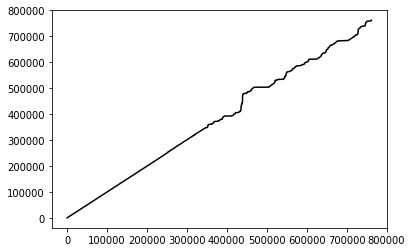

Elapsed time in seconds: 25.876489639282227


In [21]:
start = time.time()


solar_dtw_path = fast_dtw_on_stellar_spectra(tel_flux, solar_flux, euclidean_norm)

end = time.time()
print('Elapsed time in seconds: {}'.format(end - start))

In [22]:
solar_dtw_path

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [23]:
zipped_path = zip(solar_dtw_path[0], solar_dtw_path[1])

In [24]:
path_dict = defaultdict(list)
for i, j in zipped_path:
    path_dict[j].append(i)

In [25]:
aligned_tel = []    
for i, j in path_dict.items():
    aj = [tel_flux[t] for t in j]
    aligned_tel.insert(i, np.mean(aj))

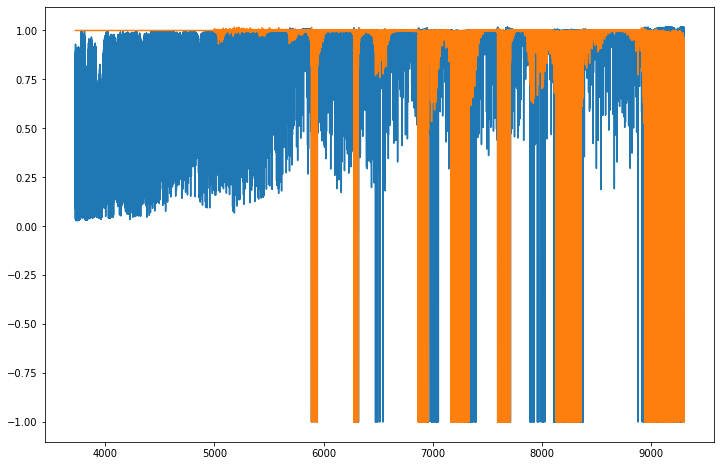

In [47]:
plt.plot(wl_ardata, solar_flux, '-')
plt.plot(wl_ardata, tel_flux, '-')

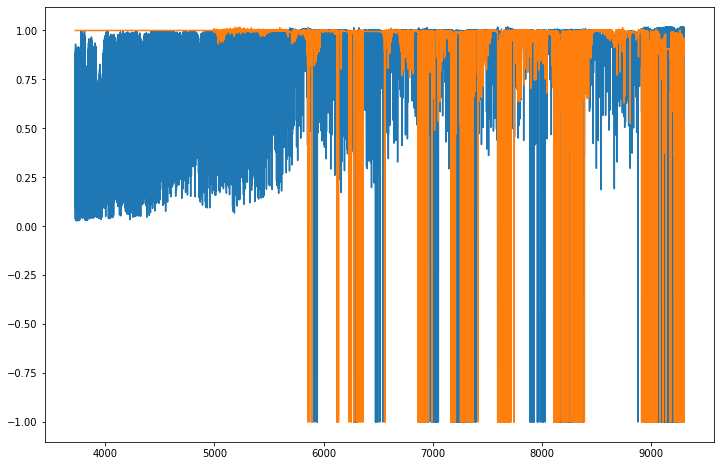

In [48]:
plt.plot(wl_ardata, solar_flux, '-')
plt.plot(wl_ardata, aligned_tel, '-')

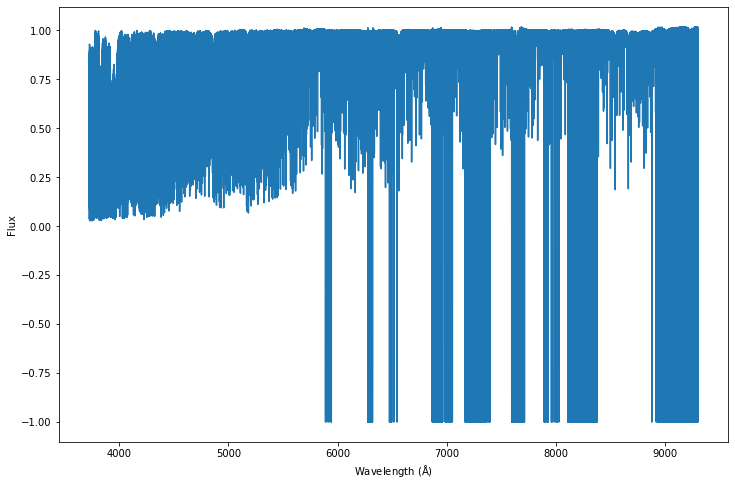

In [44]:
plot_spectrum(wl_ardata, solar_flux)

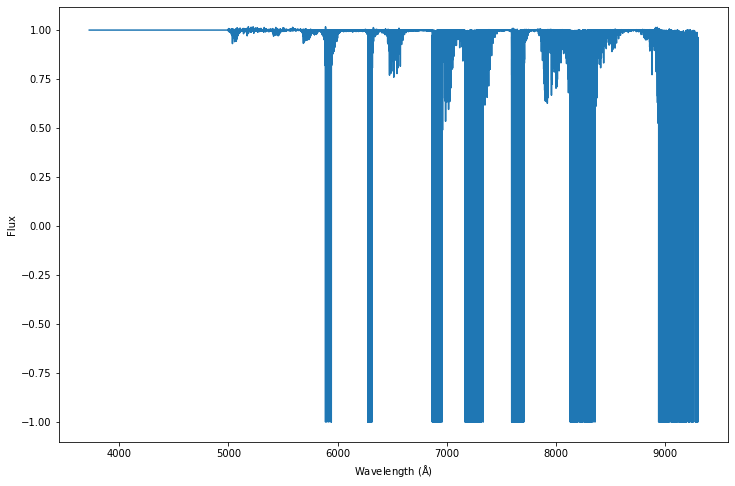

In [45]:
plot_spectrum(wl_ardata, tel_flux)

<IPython.core.display.Javascript object>


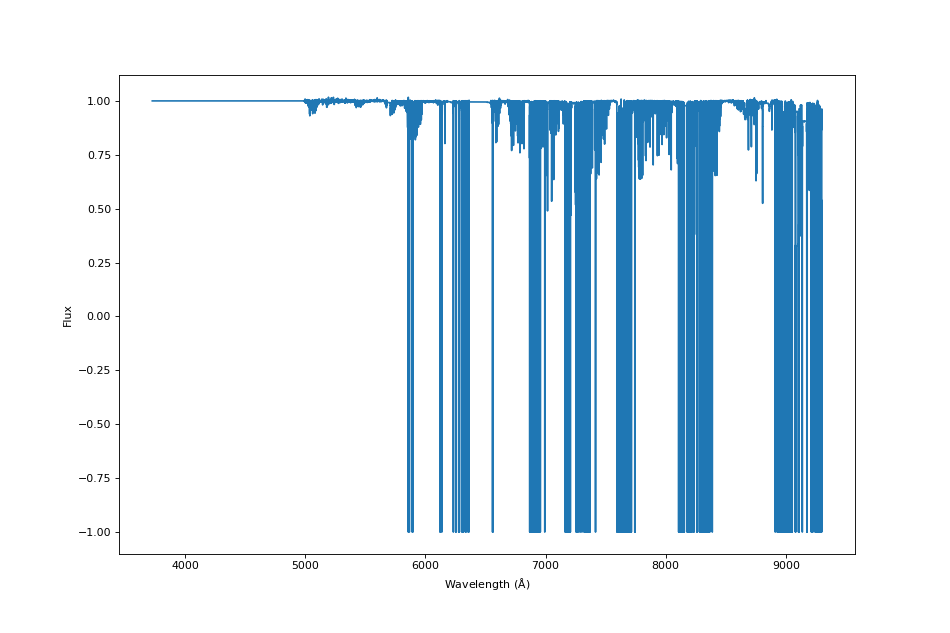

In [38]:
plot_spectrum(wl_ardata, aligned_tel)

<IPython.core.display.Javascript object>


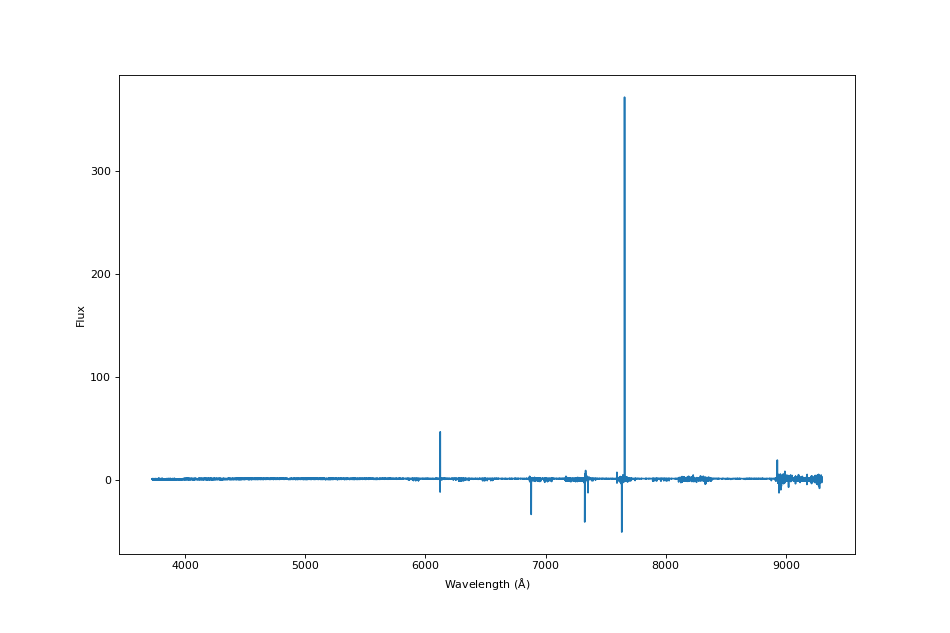

In [39]:
divided_spectrum_sun_aligned = solar_flux / aligned_tel
plot_spectrum(wl_ardata, divided_spectrum_sun_aligned)

In [ ]:
# start = time.time()


# fast_dtw_on_stellar_spectra(arcturus_flux, tel_flux, euclidean_norm)
# #distance, path = fastdtw(solar_flux, tel_flux, dist=euclidean_norm)

# end = time.time()
# print('Elapsed time in seconds: {}'.format(end - start))

Como continuar à partir do path para chegar na divisão dos espectros? Existem medidas de similaridade que melhor refletem o contexto físico do problema?  